# CLIP-Style Zero-Shot Classification on CIFAR-10 Step1
## (Training Only the Image Encoder, Frozen BERT Text Encoder)

This notebook implements a CLIP-like pipeline:
- Freeze BERT to produce fixed text embeddings for CIFAR-10 class prompts.
- Train only the ViT image encoder (vit_base_patch16_224.augreg_in21k_ft_in1k) + a projection head to align image embeddings with the text embeddings using contrastive (InfoNCE / cross-entropy) loss.
- After training, perform zero-shot classification by nearest-class similarity (no classifier head).

Note:
- CIFAR-10 images (32×32) are resized to 224×224.
- Text embeddings use multiple prompt templates and [CLS] token from BERT.
- Training is efficient because only the image side is updated.

In [30]:
import torch
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "NO GPU")

!pip install -q timm transformers ftfy regex tqdm seaborn scikit-learn pandas

GPU: Tesla T4


In [31]:
# Cell 1: Install dependencies (run once)
!pip install torch torchvision transformers timm tqdm --quiet

In [32]:
# Cell 2: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from transformers import BertTokenizer, BertModel
import timm
import numpy as np
from tqdm import tqdm

In [33]:
# Cell 3: Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [34]:
# Cell 4 (Updated): Dataset and DataLoader – Reduced batch size
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 128  # Reduced from 256
accumulation_steps = 2  # Effective batch size = 128 × 2 = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
testloader  = DataLoader(testset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

classes = trainset.classes
print("Classes:", classes)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [35]:
# Cell 5: Frozen Text Encoder (BERT) + Text Embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_model = BertModel.from_pretrained('bert-base-uncased').to(device)
text_model.eval()
for param in text_model.parameters():
    param.requires_grad = False

# Multiple templates for better text embeddings (common CLIP trick)
templates = [
    "a photo of a {}.",
    "a photo of a small {}.",
    "a photo of the {}.",
    "an image of a {}.",
    "an image of the {}."
]

def encode_texts(prompts):
    inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = text_model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token
    return embeddings

# Compute averaged text embeddings over templates
text_emb_list = []
for template in templates:
    prompts = [template.format(c) for c in classes]
    emb = encode_texts(prompts)
    text_emb_list.append(emb)

text_embeddings = torch.stack(text_emb_list).mean(dim=0)  # (10, 768)
text_embeddings = F.normalize(text_embeddings, dim=-1)
print("Text embeddings shape:", text_embeddings.shape)

# Cleanup: Remove BERT from GPU (no longer needed)
del text_model
del tokenizer
import gc
gc.collect()
torch.cuda.empty_cache()

Text embeddings shape: torch.Size([10, 768])


In [36]:
# Cell 6: Image Encoder (ViT) + Projection + Logit Scale
# num_classes=0 removes the classification head → raw features (384-dim for ViT-S)
image_model = timm.create_model(
    'vit_base_patch16_224.augreg_in21k_ft_in1k',  # Changed to ViT-Base/16 (strong pretrained)
    pretrained=True,
    num_classes=0  # Raw features (returns CLS token embedding, dim=768)
).to(device)

projection = nn.Linear(768, 768).to(device)  # Updated: 768 → 768 to match BERT text dim
logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

In [37]:
# Cell 7 (Updated): Optimizer + AMP Scaler
optimizer = torch.optim.AdamW(
    list(image_model.parameters()) + list(projection.parameters()) + [logit_scale],
    lr=5e-5,
    weight_decay=0.01
)

scaler = torch.cuda.amp.GradScaler()  # For mixed precision

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

/tmp/ipython-input-1430465287.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For mixed precision


Epoch 1 completed - Avg Loss: 1.1122 - Train Acc: 98.81% - Test Acc: 97.56%


Epoch 2/5: 100%|██████████| 391/391 [06:13<00:00,  1.05it/s]


Epoch 2 completed - Avg Loss: 0.9870 - Train Acc: 99.54% - Test Acc: 97.91%


Epoch 3/5: 100%|██████████| 391/391 [06:11<00:00,  1.05it/s]


Epoch 3 completed - Avg Loss: 0.9727 - Train Acc: 98.92% - Test Acc: 96.90%


Epoch 4/5: 100%|██████████| 391/391 [06:10<00:00,  1.05it/s]


Epoch 4 completed - Avg Loss: 0.9609 - Train Acc: 99.21% - Test Acc: 97.10%


Epoch 5/5: 100%|██████████| 391/391 [06:09<00:00,  1.06it/s]


Epoch 5 completed - Avg Loss: 0.9518 - Train Acc: 99.44% - Test Acc: 97.39%
Final model checkpoint saved to 'checkpoints/final_model.pth'


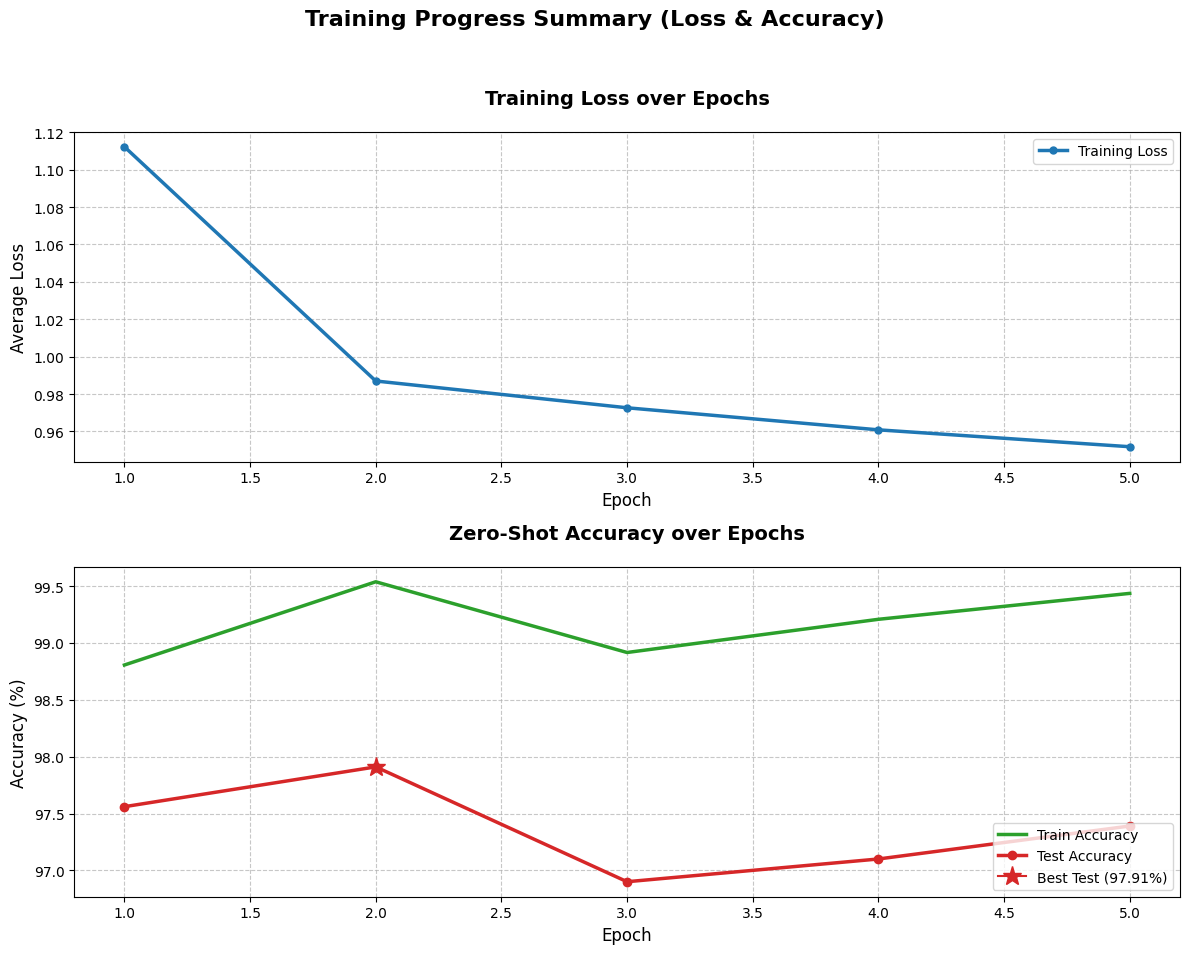

Epoch 1/5:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-1462326434.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/5:  26%|██▌       | 102/391 [01:39<04:39,  1.03it/s]

In [28]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm  # Already used in training, but ensure imported

# Create checkpoints directory if it doesn't exist
os.makedirs('checkpoints', exist_ok=True)

# Zero-shot accuracy computation (assumes testloader exists from previous cells)
@torch.no_grad()
def zero_shot_accuracy(loader):
    image_model.eval()
    projection.eval()
    correct = 0
    total = 0
    for images, labels in loader:  # No tqdm here to keep evaluation fast
        images = images.to(device)
        labels = labels.to(device)

        image_features = image_model(images)
        image_features = projection(image_features)
        image_features = F.normalize(image_features, dim=-1)

        logits = logit_scale.exp() * image_features @ text_embeddings.T
        preds = logits.argmax(dim=-1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100. * correct / total
    image_model.train()
    projection.train()
    return acc

epochs = 5

# Lists/metrics for plotting and checkpointing
losses = []
train_accs = []
test_accs = []

for epoch in range(epochs):
    image_model.train()
    projection.train()
    total_loss = 0.0
    optimizer.zero_grad()  # Zero once at start of epoch

    for i, (images, labels) in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}")):
        images = images.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast():
            image_features = image_model(images)
            image_features = projection(image_features)
            image_features = F.normalize(image_features, dim=-1)

            logits = logit_scale.exp() * image_features @ text_embeddings.T
            loss = F.cross_entropy(logits, labels)
            loss = loss / accumulation_steps  # Scale loss for accumulation

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(trainloader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps  # Unscale for logging

    scheduler.step()
    avg_loss = total_loss / len(trainloader)

    # Store loss
    losses.append(avg_loss)

    # Compute and store train accuracy (every epoch)
    train_acc = zero_shot_accuracy(trainloader)
    train_accs.append(train_acc)

    # Compute and store test accuracy (every epoch)
    test_acc = zero_shot_accuracy(testloader)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1} completed - Avg Loss: {avg_loss:.4f} - Train Acc: {train_acc:.2f}% - Test Acc: {test_acc:.2f}%")

    # Optional: Clear cache every few epochs
    if (epoch + 1) % 5 == 0:
        torch.cuda.empty_cache()

# Save final checkpoint only (at the very end)
final_test_acc = test_accs[-1]
torch.save({
    'epoch': epochs,
    'image_model_state_dict': image_model.state_dict(),
    'projection_state_dict': projection.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'scaler_state_dict': scaler.state_dict(),
    'logit_scale': logit_scale,
    'avg_loss': losses[-1],
    'final_test_acc': final_test_acc,
}, 'checkpoints/final_model.pth')
print("Final model checkpoint saved to 'checkpoints/final_model.pth'")

# === Professional plotting after training ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=100)

# Training Loss
ax1.plot(range(1, epochs + 1), losses, color='tab:blue', linewidth=2.5, marker='o', markersize=5)
ax1.set_title('Training Loss over Epochs', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Average Loss', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(['Training Loss'], loc='upper right')

# Accuracy
ax2.plot(range(1, epochs + 1), train_accs, color='tab:green', linewidth=2.5, label='Train Accuracy')
ax2.plot(range(1, epochs + 1), test_accs, color='tab:red', linewidth=2.5, marker='o', markersize=6, label='Test Accuracy')

# Highlight best test accuracy
if test_accs:
    best_test_val = max(test_accs)
    best_test_idx = test_accs.index(best_test_val)
    best_test_epoch = best_test_idx + 1
    ax2.plot(best_test_epoch, best_test_val, color='tab:red', marker='*', markersize=14,
             label=f'Best Test ({best_test_val:.2f}%)')

ax2.set_title('Zero-Shot Accuracy over Epochs', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(loc='lower right')

# Overall styling
fig.suptitle('Training Progress Summary (Loss & Accuracy)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [29]:
checkpoint = torch.load('checkpoints/best_model.pth')
image_model.load_state_dict(checkpoint['image_model_state_dict'])
projection.load_state_dict(checkpoint['projection_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
scaler.load_state_dict(checkpoint['scaler_state_dict'])
# logit_scale = checkpoint['logit_scale']  # if needed

# Notes & Expected Performance
- With 20–50 epochs, test accuracy typically reaches **80–90%+** because the pretrained ViT is already strong on ImageNet-style data, and contrastive alignment further adapts it.
- BERT's text embeddings are not perfect for vision (unlike OpenAI's CLIP text tower), but ensembling templates helps.
- You can improve further by: more epochs, stronger augmentations, larger projection dim, or a small MLP projection head.
- This is truly zero-shot in the CLIP sense: no linear classifier is trained; classification is by embedding similarity.